# Time Series Synthetic Data Generation with VAE

An experiment for synthetic data generation __without using a seq2seq__ deep learning model (such as - RNN, LSTM, GRU, etc). The idea is to use the dataset _without shuffling_ to preserve it's time series nature and get the reconstructed data points from the trained VAE. A loss such as _mean squared error_ can be used to gauge feature-wise loss for subsequent analysis.

[Dataset source](https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# import torchvision
# import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [2]:
print(f"torch version: {torch.__version__}")

torch version: 1.9.0


In [3]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

Number of GPU(s) available = 0


In [4]:
if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

PyTorch does not have access to GPU


In [5]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cpu


In [6]:
# Read-in dataset-
data = pd.read_csv("C:\\Users\\Arjun\\Downloads\\jena_climate_2009_2016.csv")

In [7]:
data.shape

(420551, 15)

In [8]:
data.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [9]:
# Convert 'Dae Time' column to datetime-
data['Date Time'] = pd.to_datetime(data['Date Time'])

In [10]:
# Sort in increasing order for 'Date Time' column-
data.sort_values(by = 'Date Time', ascending = True, inplace = True)

In [11]:
# Check for missing values-
data.isna().values.any()
# False

False

In [12]:
# Check for missing values-
data.isna().sum().sum()
# 0

0

In [13]:
# Select desired attributes/features/variables/channels/columns-
cols = [
    'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
    'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
    'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
    'wd (deg)'
]

<Figure size 720x576 with 0 Axes>

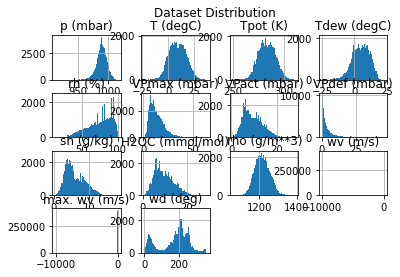

In [14]:
plt.figure(figsize = (10, 8))

data.loc[:, cols].hist(bins = int(np.ceil(np.sqrt(len(data)))))

plt.suptitle("Dataset Distribution")
plt.show()

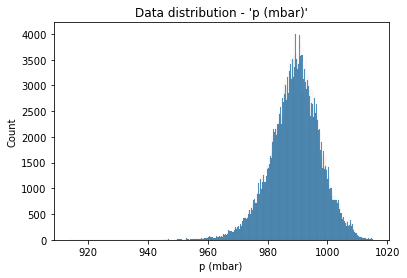

In [15]:
sns.histplot(data = data, x = 'p (mbar)', bins = int(np.ceil(np.sqrt(len(data)))))
plt.title("Data distribution - 'p (mbar)'")
plt.show()

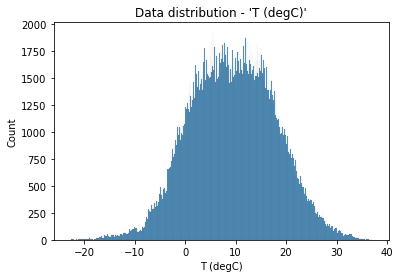

In [16]:
sns.histplot(data = data, x = 'T (degC)', bins = int(np.ceil(np.sqrt(len(data)))))
plt.title("Data distribution - 'T (degC)'")
plt.show()

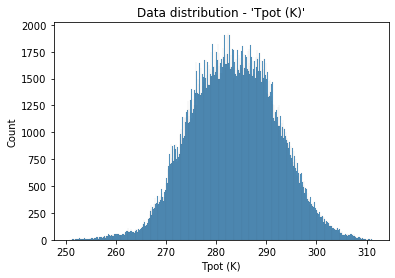

In [17]:
sns.histplot(data = data, x = 'Tpot (K)', bins = int(np.ceil(np.sqrt(len(data)))))
plt.title("Data distribution - 'Tpot (K)'")
plt.show()

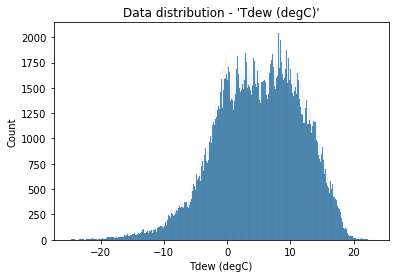

In [18]:
sns.histplot(data = data, x = 'Tdew (degC)', bins = int(np.ceil(np.sqrt(len(data)))))
plt.title("Data distribution - 'Tdew (degC)'")
plt.show()

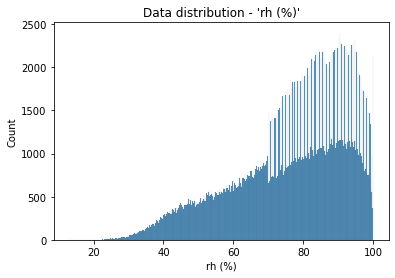

In [19]:
sns.histplot(data = data, x = 'rh (%)', bins = int(np.ceil(np.sqrt(len(data)))))
plt.title("Data distribution - 'rh (%)'")
plt.show()

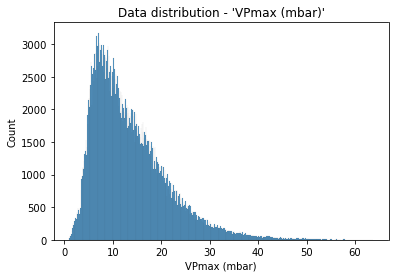

In [20]:
sns.histplot(data = data, x = 'VPmax (mbar)', bins = int(np.ceil(np.sqrt(len(data)))))
plt.title("Data distribution - 'VPmax (mbar)'")
plt.show()

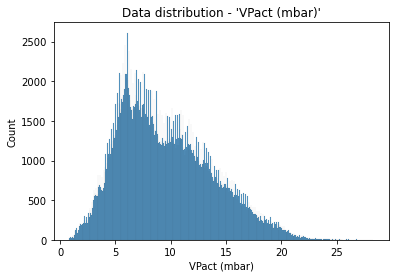

In [21]:
sns.histplot(data = data, x = 'VPact (mbar)', bins = int(np.ceil(np.sqrt(len(data)))))
plt.title("Data distribution - 'VPact (mbar)'")
plt.show()

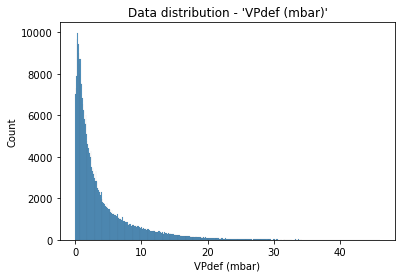

In [22]:
sns.histplot(data = data, x = 'VPdef (mbar)', bins = int(np.ceil(np.sqrt(len(data)))))
plt.title("Data distribution - 'VPdef (mbar)'")
plt.show()

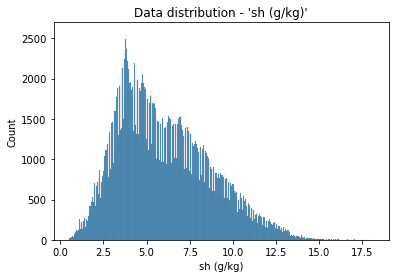

In [23]:
sns.histplot(data = data, x = 'sh (g/kg)', bins = int(np.ceil(np.sqrt(len(data)))))
plt.title("Data distribution - 'sh (g/kg)'")
plt.show()

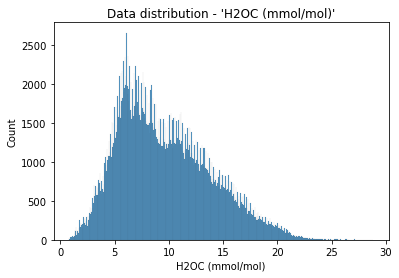

In [24]:
sns.histplot(data = data, x = 'H2OC (mmol/mol)', bins = int(np.ceil(np.sqrt(len(data)))))
plt.title("Data distribution - 'H2OC (mmol/mol)'")
plt.show()

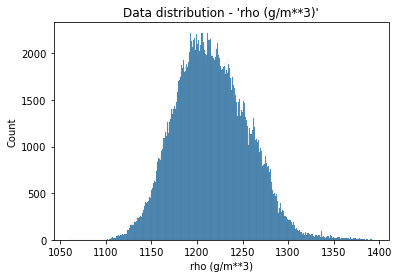

In [25]:
sns.histplot(data = data, x = 'rho (g/m**3)', bins = int(np.ceil(np.sqrt(len(data)))))
plt.title("Data distribution - 'rho (g/m**3)'")
plt.show()

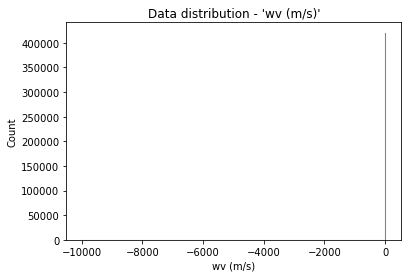

In [26]:
sns.histplot(data = data, x = 'wv (m/s)', bins = int(np.ceil(np.sqrt(len(data)))))
plt.title("Data distribution - 'wv (m/s)'")
plt.show()

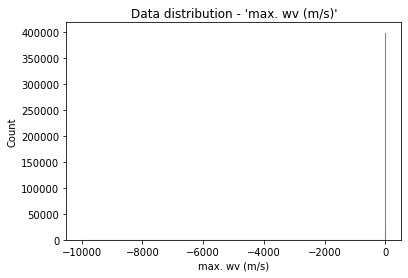

In [27]:
sns.histplot(data = data, x = 'max. wv (m/s)', bins = int(np.ceil(np.sqrt(len(data)))))
plt.title("Data distribution - 'max. wv (m/s)'")
plt.show()

In [28]:
data['max. wv (m/s)'].min(), data['max. wv (m/s)'].max()

(-9999.0, 23.5)

In [29]:
data['wv (m/s)'].min(), data['wv (m/s)'].max()

(-9999.0, 28.49)

In [30]:
data.loc[data['wv (m/s)'] < 0, 'wv (m/s)']

343578   -9999.0
343579   -9999.0
343580   -9999.0
343581   -9999.0
343582   -9999.0
343583   -9999.0
343584   -9999.0
343585   -9999.0
343586   -9999.0
343587   -9999.0
343588   -9999.0
343589   -9999.0
343590   -9999.0
343591   -9999.0
343592   -9999.0
343593   -9999.0
343594   -9999.0
343595   -9999.0
Name: wv (m/s), dtype: float64

In [31]:
data.loc[data['max. wv (m/s)'] < 0, 'max. wv (m/s)']

343577   -9999.0
343578   -9999.0
343579   -9999.0
343580   -9999.0
343581   -9999.0
343582   -9999.0
343583   -9999.0
343584   -9999.0
343585   -9999.0
343586   -9999.0
343587   -9999.0
343588   -9999.0
343589   -9999.0
343590   -9999.0
343591   -9999.0
343592   -9999.0
343593   -9999.0
343594   -9999.0
343595   -9999.0
343596   -9999.0
Name: max. wv (m/s), dtype: float64

### Observation:

- _max. wv (m/s)_ and _wv (m/s)_ cannot be negative! Data is faulty and/or corrupt.

- not a lot of values are negative.

In [32]:
# Replace negative values by 0-
data.loc[data['wv (m/s)'] < 0, 'wv (m/s)'] = 0

In [33]:
# Replace negative values by 0-
data.loc[data['max. wv (m/s)'] < 0, 'max. wv (m/s)'] = 0

In [34]:
# Sanity check-
data.loc[data['wv (m/s)'] < 0, 'wv (m/s)']

Series([], Name: wv (m/s), dtype: float64)

In [35]:
# Sanity check-
data.loc[data['max. wv (m/s)'] < 0, 'max. wv (m/s)']

Series([], Name: max. wv (m/s), dtype: float64)

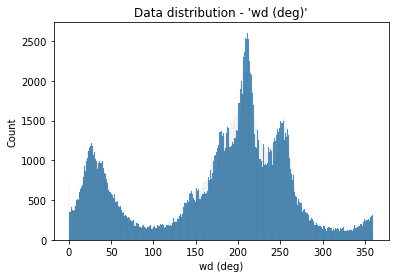

In [36]:
sns.histplot(data = data, x = 'wd (deg)', bins = int(np.ceil(np.sqrt(len(data)))))
plt.title("Data distribution - 'wd (deg)'")
plt.show()

### Future Works

Skewed features can be normalized before scaling to further improve the VAE's reconstructions.

### Data Scaling

1. If data is scaled between 0 to 1 using ```MinxMaxScaler()```, then last layer of VAE uses _sigmoid_ activation function and the _reconstruction loss_ is ```BCEloss```.

1. If data is scaled between -1 to 1 using ```MinxMaxScaler()```, then last layer of VAE uses _tanh_ activation function and the _reconstruction loss_ is ```MSEloss```.


In [37]:
# Initialize a MinMax scaler-
mm_scaler = MinMaxScaler(feature_range = (-1, 1))

In [ ]:
# Initialize standard scaler-
# std_scaler = StandardScaler()

In [38]:
# data_scaled = std_scaler.fit_transform(data.loc[:, cols].to_numpy())
data_scaled = mm_scaler.fit_transform(data.loc[:, cols].to_numpy())

In [39]:
data_scaled = pd.DataFrame(data_scaled, columns = cols)

In [40]:
data_scaled.shape

(420551, 14)

In [41]:
data_scaled.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,0.629877,-0.502737,-0.512677,-0.330424,0.846065,-0.924228,-0.831457,-0.990437,-0.836642,-0.834404,0.486426,-0.927694,-0.851064,-0.153889
1,0.630860,-0.515674,-0.525519,-0.346218,0.848363,-0.927412,-0.837995,-0.990872,-0.842314,-0.840828,0.498698,-0.949456,-0.872340,-0.243889
2,0.630074,-0.518992,-0.528811,-0.347465,0.859851,-0.928048,-0.838721,-0.991306,-0.843449,-0.841542,0.501332,-0.986662,-0.946383,-0.046667
3,0.629681,-0.512357,-0.521897,-0.337490,0.866743,-0.926457,-0.834363,-0.991741,-0.838911,-0.837259,0.495046,-0.976132,-0.957447,0.100000
4,0.629681,-0.511030,-0.520909,-0.336243,0.864446,-0.926138,-0.833636,-0.991741,-0.838911,-0.836545,0.493909,-0.977536,-0.946383,0.190556


In [42]:
data_scaled.columns

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [64]:
dataset_tensor = torch.tensor(data_scaled.to_numpy(), dtype = torch.float32)
# train_tensor = torch.tensor(train.values)

In [65]:
dataset_tensor.shape

torch.Size([420551, 14])

In [ ]:
# std_scaler.inverse_transform(data_scaled)

### Time Series data preparation for VAE

Make sure to split the _processed_ data __without shuffling to preserve it's time series nature__.

In [ ]:
# len(data_scaled)
# 420551

In [ ]:
# 80-20 train-test split-
# int(np.ceil(0.8 * len(data_scaled)))
# 336441

In [ ]:
# Split data into training and testing sets-
# X_train = data_scaled.loc[:336440, :]
# X_test = data_scaled.loc[336441:, :]

In [ ]:
# Sanity check-
# X_train.shape, X_test.shape, data_scaled.shape
# ((336441, 14), (84110, 14), (420551, 14))

In [ ]:
# len(X_train) + len(X_test) == len(data_scaled)
# True

In [ ]:
# len(X_train) + len(X_test)
# 420551

In [ ]:
# Convert from pd.DataFrame to np arrays-
# X_train = X_train.to_numpy()
# X_test = X_test.to_numpy()

### Create ```Dataset``` for CSV file in PyTorch

- [Refer](https://shashikachamod4u.medium.com/excel-csv-to-pytorch-dataset-def496b6bcc1)

- G: read csv file in pytorch

In [32]:
class TimeSeriesDataset(Dataset):
    def __init__(self, filename):
        data = pd.read_csv(filename)
        
        # Convert 'Dae Time' column to datetime-
        data['Date Time'] = pd.to_datetime(data['Date Time'])
        
        # Sort in increasing order for 'Date Time' column-
        data.sort_values(by = 'Date Time', ascending = True, inplace = True)
        
        # Select desired attributes/features/variables/channels/columns-
        cols = [
            'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
            'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
            'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
            'wd (deg)'
        ]

        # Replace negative values by 0-
        data.loc[data['wv (m/s)'] < 0, 'wv (m/s)'] = 0
        
        # Replace negative values by 0-
        data.loc[data['max. wv (m/s)'] < 0, 'max. wv (m/s)'] = 0
        
        # Initialize a MinMax scaler-
        mm_scaler = MinMaxScaler(feature_range = (0, 1))
        data_scaled = mm_scaler.fit_transform(data.loc[:, cols].to_numpy())
        
        # Convert from np array to pd.DataFrame-
        # data_scaled = pd.DataFrame(data_scaled, columns = cols)
        
        # Convert to torch tensors-
        self.data_scaled = torch.tensor(data_scaled, dtype = torch.float32)
    
    
    def __len__(self):
        return len(self.data_scaled)
    
    
    def __getitem__(self, idx):
        return self.data_scaled[idx]
        


In [ ]:
# Instantiate dataset-
# dataset = TimeSeriesDataset(filename = "C:\\Users\\Arjun\\Downloads\\jena_climate_2009_2016.csv")

In [ ]:
# print(f"length of dataset = {len(dataset)}")
# length of dataset = 420551

In [46]:
# Specify hyper-parameters-
batch_size = 64
num_epochs = 200
learning_rate = 0.001

In [66]:
# Create data loader-
data_loader = DataLoader(
    dataset = dataset_tensor, batch_size = batch_size,
    shuffle = False
)

In [67]:
print(f"len(data_loader) = {len(data_loader)}")

len(data_loader) = 6572


In [68]:
# Sanity check-
len(dataset_tensor) / batch_size

6571.109375

In [69]:
# Get some batch of data-
x = next(iter(data_loader))

# You get 32 data points due to the specified batch size-
print(f"x.shape: {x.shape}")

x.shape: torch.Size([64, 14])


In [70]:
del x

### Define _Variational Autoencoder_ architecture:

In [79]:
class VAE_TimeSeries(nn.Module):
    def __init__(self, latent_space = 10):
        super(VAE_TimeSeries, self).__init__()
        
        self.latent_space = latent_space
        
        # Encoder-
        self.enc_layer1 = nn.Linear(
            in_features = 14, out_features = 300,
            bias = True
        )
        self.enc_layer2 = nn.Linear(
            in_features = 300, out_features = 150,
            bias = True
        )
        self.enc_layer3 = nn.Linear(
            in_features = 150, out_features = 70,
            bias = True
        )
        self.enc_layer4 = nn.Linear(
            in_features = 70, out_features = 30,
            bias = True
        )
        self.enc_output = nn.Linear(
            in_features = 30, out_features = self.latent_space,
            bias = True
        )
        
        # Two additional layers 'hidden2mu' & 'hidden2log' to convert the bottleneck into the μ and σ vectors-
        self.hidden2mu = nn.Linear(
            in_features = self.latent_space, out_features = self.latent_space,
            bias = True
        )
        self.hidden2log_var = nn.Linear(
            in_features = self.latent_space, out_features = self.latent_space,
            bias = True
        )
        
        # Decoder-
        self.dec_layer1 = nn.Linear(
            in_features = self.latent_space, out_features = 30,
            bias = True
        )
        self.dec_layer2 = nn.Linear(
            in_features = 30, out_features = 70,
            bias = True
        )
        self.dec_layer3 = nn.Linear(
            in_features = 70, out_features = 150,
            bias = True
        )
        self.dec_layer4 = nn.Linear(
            in_features = 150, out_features = 300,
            bias = True
        )
        self.dec_output = nn.Linear(
            in_features = 300, out_features = 14,
            bias = True
        )
        
        
    def reparameterize(self, mu, log_var):
        '''
        Input arguments:
        1. mu - mean coming from the encoder's latent space
        2. log_var - log variance coming from the encoder's latent space
        '''
        # Compute standard deviation using 'log_var'-
        std = torch.exp(0.5 * log_var)
        
        # 'eps' samples from a normal standard distribution to add
        # stochasticity to the sampling process-
        eps = torch.randn_like(std)
        
        # Reparameterization trick - sample as if it's from the input
        # space-
        sample = mu + (std * eps)
        
        return sample
    
    
    def forward(self, x):
        # Encode input data-
        x = F.relu(self.enc_layer1(x))
        x = F.relu(self.enc_layer2(x))
        x = F.relu(self.enc_layer3(x))
        x = F.relu(self.enc_layer4(x))
        x = F.relu(self.enc_output(x))
        # NOTE: The line of code above does NOT give us the latent vector!
        
        # print(f"encoder's output x.shape: {x.shape}")
        
        mu = self.hidden2mu(x)
        log_var = self.hidden2log_var(x)
        
        # Obtain the latent vector using reparameterization-
        z = self.reparameterize(mu, log_var)
        # latent vector 'z' is obtained through reparameterization trick using mu and log_var
        
        '''
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape} &"
              f" z.shape: {z.shape}")
        '''
        
        # Decode latent vector-
        x = F.relu(self.dec_layer1(x))
        x = F.relu(self.dec_layer2(x))
        x = F.relu(self.dec_layer3(x))
        x = F.relu(self.dec_layer4(x))
        recon_data = torch.tanh(self.dec_output(x))
        # recon_data = torch.sigmoid(self.dec_output(x))

        return recon_data, mu, log_var

    

In [80]:
# Initialize model-
model = VAE_TimeSeries(latent_space = 10).to(device)

In [81]:
print(model)

VAE_TimeSeries(
  (enc_layer1): Linear(in_features=14, out_features=300, bias=True)
  (enc_layer2): Linear(in_features=300, out_features=150, bias=True)
  (enc_layer3): Linear(in_features=150, out_features=70, bias=True)
  (enc_layer4): Linear(in_features=70, out_features=30, bias=True)
  (enc_output): Linear(in_features=30, out_features=10, bias=True)
  (hidden2mu): Linear(in_features=10, out_features=10, bias=True)
  (hidden2log_var): Linear(in_features=10, out_features=10, bias=True)
  (dec_layer1): Linear(in_features=10, out_features=30, bias=True)
  (dec_layer2): Linear(in_features=30, out_features=70, bias=True)
  (dec_layer3): Linear(in_features=70, out_features=150, bias=True)
  (dec_layer4): Linear(in_features=150, out_features=300, bias=True)
  (dec_output): Linear(in_features=300, out_features=14, bias=True)
)


In [82]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([300, 14]) has 4200 parameters
layer.shape = torch.Size([300]) has 300 parameters
layer.shape = torch.Size([150, 300]) has 45000 parameters
layer.shape = torch.Size([150]) has 150 parameters
layer.shape = torch.Size([70, 150]) has 10500 parameters
layer.shape = torch.Size([70]) has 70 parameters
layer.shape = torch.Size([30, 70]) has 2100 parameters
layer.shape = torch.Size([30]) has 30 parameters
layer.shape = torch.Size([10, 30]) has 300 parameters
layer.shape = torch.Size([10]) has 10 parameters
layer.shape = torch.Size([10, 10]) has 100 parameters
layer.shape = torch.Size([10]) has 10 parameters
layer.shape = torch.Size([10, 10]) has 100 parameters
layer.shape = torch.Size([10]) has 10 parameters
layer.shape = torch.Size([30, 10]) has 300 parameters
layer.shape = torch.Size([30]) has 30 parameters
layer.shape = torch.Size([70, 30]) has 2100 parameters
layer.shape = torch.Size([70]) has 70 parameters
layer.shape = torch.Size([150, 70]) has 10500 parameters
l

In [83]:
print(f"Total number of parameters in VAE Dense model = {tot_params}")

Total number of parameters in VAE Dense model = 125544


In [84]:
x = next(iter(data_loader))

In [85]:
x.shape

torch.Size([64, 14])

In [86]:
# Sanity check-
recon_data, mu, log_var = model(x)

In [87]:
recon_data.shape, x.shape

(torch.Size([64, 14]), torch.Size([64, 14]))

In [88]:
mu.shape, log_var.shape

(torch.Size([64, 10]), torch.Size([64, 10]))

In [89]:
del recon_data, x, mu, log_var

#### Initial variance - Sanity check:

Before training the VAE neural network model, there should be some initial variance.

In [90]:
for x in model.hidden2mu.parameters():
    print(x.shape, x.nelement())

torch.Size([10, 10]) 100
torch.Size([10]) 10


In [91]:
log_var_wts = model.hidden2log_var.weight
log_var_wts = log_var_wts.detach().cpu().numpy()

In [92]:
mu_wts = model.hidden2mu.weight
mu_wts = mu_wts.detach().cpu().numpy()

In [93]:
mu_wts.shape, log_var_wts.shape

((10, 10), (10, 10))

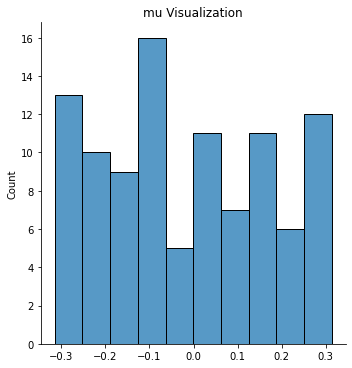

In [94]:
sns.displot(data = mu_wts.flatten(), bins = int(np.ceil(np.sqrt(mu_wts.size))))
plt.title("mu Visualization")
plt.show()

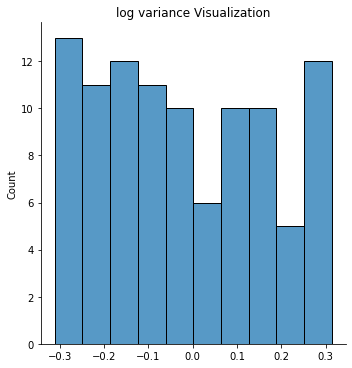

In [95]:
sns.displot(data = log_var_wts.flatten(), bins = int(np.ceil(np.sqrt(log_var_wts.size))))
plt.title("log variance Visualization")
plt.show()

In [96]:
del log_var_wts, mu_wts

In [97]:
print(f"Adam optimizer with learning rate = {learning_rate} will be used")

Adam optimizer with learning rate = 0.001 will be used


In [98]:
# Define gradient descent optimizer-
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [99]:
# Reconstruction loss-
# criterion = nn.BCELoss(reduction = 'sum')

# Note: reduction='sum' is used for the BCELoss(). If you read the PyTorch documentations, then this is
# specifically for the case of autoencoders only.

# MSE loss could also be used-
criterion = nn.MSELoss(reduction = 'sum')

In [100]:
def total_loss(reconstruction_loss, mu, log_var, alpha = 1):
    '''
    Function to add reconstruction loss and KL-Divergence loss.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    Inputs:
    1. recontruction loss - BCE or MSE loss
    2. mu: mean from the latent vector
    3. logvar: log variance from the latent vector
    4. alpha (int): Hyperparameter to control the importance of reconstruction
    loss vs KL-Divergence Loss.
    '''
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    # final_loss = reconstruction_loss + KLD
    final_loss = (reconstruction_loss * alpha) + KLD
    
    return final_loss


In [105]:
def train_one_epoch(model, dataloader, dataset, alpha):
    
    # Place model to device-
    model.to(device)
    
    # Enable training mode-
    model.train()
    
    running_loss = 0.0
    
    for i, data in tqdm(enumerate(dataloader), total = int(len(dataset) / dataloader.batch_size)):
        data = data
        data = data.to(device)
        
        # Flatten input data to feed into a dense layer-
        # data = data.view(data.size(0), -1)
        
        # Empty accumulated gradients-
        optimizer.zero_grad()
        
        # Perform forward propagation-
        reconstruction, mu, logvar = model(data)
        
        # Compute reconstruction loss-
        recon_loss = criterion(reconstruction, data)
        
        # Compute final loss-
        loss = total_loss(recon_loss, mu, logvar, alpha)
        
        # Update loss-
        running_loss += loss.item()
        
        # Compute gradients wrt loss-
        loss.backward()
        
        # Perform gradient descent-
        optimizer.step()
        
    train_loss = running_loss / len(dataloader.dataset)
    
    return train_loss, mu, logvar


In [ ]:
"""
def validate_one_epoch(model, dataloader, alpha):
    
    # Place model to device-
    model.to(device)
    
    # Enable evaluation mode-
    model.eval()
    
    running_loss = 0.0
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(data_loader), total = int(len(dataset) / dataloader.batch_size)):
            data = data
            data = data.to(device)
            
            # Flatten data to feed into a dense layer-
            # data = data.view(data.size(0), -1)
            
            # Forward propagation-
            reconstruction, mu, logvar = model(data)
            
            # Compute reconstruction loss-
            bce_loss = criterion(reconstruction, data)
            
            # Compute total loss-
            loss = total_loss(bce_loss, mu, logvar, alpha)
            
            # Update loss-
            running_loss += loss.item()

            '''
            # save the last batch input and output of every epoch
            if i == int(len(test_dataset) / dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction.view(batch_size, 1, 28, 28)[:8]))
                save_image(both.cpu(), f"../outputs/output{epoch}.png", nrow=num_rows)
            '''
            
    val_loss = running_loss / len(dataloader.dataset)
    
    return val_loss, mu, logvar

"""

In [ ]:
'''
# Sanity check-
train_loss, mu, logvar = train_one_epoch(
    model = model, dataloader = data_loader,
    dataset = dataset_tensor, alpha = 10
)
'''

In [ ]:
# Sanity check-
# test_loss = validate_one_epoch(model = model, dataloader = test_loader, aplha = 1)

# print(f"train loss = {train_loss:.4f} & test loss = {test_loss:.4f}")

In [ ]:
# print(f"train loss = {train_loss:.4f}")
# train loss = 4.5863

In [108]:
# Specify alpha - Hyperparameter to control the importance of reconstruction
# loss vs KL-Divergence Loss-
alpha = 10

In [109]:
# Python dict to contain training metrics-
train_history = {}

In [110]:
num_epochs = 10
print(f"Training VAE model for {num_epochs} epochs")

Training VAE model for 10 epochs


In [112]:
for epoch in range(1, num_epochs + 1):
    
    # Train model for 1 epoch-
    train_epoch_loss, mu_train, logvar_train = train_one_epoch(
        model = model, dataloader = data_loader,
        dataset = dataset_tensor, alpha = 10
    )
    
    '''
    # Get validation metrics-
    val_epoch_loss, mu_val, logvar_val = validate_one_epoch(
        model = model, dataloader = test_loader,
        alpha = alpha
    )
    '''
    
    # Retrieve model performance metrics-
    logvar_train = logvar_train.mean().detach().cpu().numpy()
    # logvar_val = logvar_val.mean().detach().cpu().numpy()
    mu_train = mu_train.mean().detach().cpu().numpy()
    # mu_val = mu_val.mean().detach().cpu().numpy()

    # Store model performance metrics in Python3 dict-
    train_history[epoch] = {
        'train_loss': train_epoch_loss,
        # 'val_loss': val_epoch_loss,
        'train_logvar': logvar_train,
        # 'val_logvar': logvar_val,
        'train_mu': mu_train,
        # 'val_mu': mu_val
    }

    '''
    print(f"Epoch = {epoch}; train loss = {train_epoch_loss:.4f},"
    f"test loss = {val_epoch_loss:.4f}, train_logvar = {logvar_train:.6f}"
    f", train_mu = {mu_train:.6f}, val_logvar = {logvar_val:.6f} &"
    f" val_mu = {mu_val:.6f}")
    '''
    
    print(f"Epoch = {epoch}; train loss = {train_epoch_loss:.4f},"
          f" train_logvar = {logvar_train:.6f} & train_mu = {mu_train:.6f}"
         )
    
    

6572it [00:58, 111.90it/s]                                                                                             


Epoch = 1; train loss = 1.8011, train_logvar = 0.001863 & train_mu = 0.002006


6572it [00:59, 109.94it/s]                                                                                             


Epoch = 2; train loss = 1.4003, train_logvar = -0.001606 & train_mu = 0.001037


6572it [01:03, 104.08it/s]                                                                                             


Epoch = 3; train loss = 0.8381, train_logvar = -0.000001 & train_mu = -0.001908


6572it [01:00, 108.42it/s]                                                                                             


Epoch = 4; train loss = 0.7221, train_logvar = -0.000444 & train_mu = 0.001285


6572it [01:01, 106.99it/s]                                                                                             


Epoch = 5; train loss = 0.6479, train_logvar = 0.000821 & train_mu = 0.001611


6572it [01:00, 108.45it/s]                                                                                             


Epoch = 6; train loss = 0.6084, train_logvar = -0.000678 & train_mu = 0.000886


6572it [01:02, 104.49it/s]                                                                                             


Epoch = 7; train loss = 0.5753, train_logvar = 0.000432 & train_mu = -0.000135


6572it [01:01, 106.46it/s]                                                                                             


Epoch = 8; train loss = 0.5399, train_logvar = -0.000555 & train_mu = 0.000754


6572it [01:03, 103.37it/s]                                                                                             


Epoch = 9; train loss = 0.5293, train_logvar = -0.001901 & train_mu = 0.000048


6572it [01:05, 100.86it/s]                                                                                             

Epoch = 10; train loss = 0.5278, train_logvar = 0.001465 & train_mu = -0.000025


In [113]:
# Save trained VAE model's weights-
torch.save(model.state_dict(), 'VAE_Time_Series.pth')

In [ ]:
# Load trained weights from before-
# loaded_model = VAE_Dense(latent_space = 5).to(device)
# loaded_model.load_state_dict(torch.load('VAE_LeNet5_MNIST_Trained_Weights.pth', map_location = torch.device('cpu')))

# Define gradient descent optimizer-
# optimizer = torch.optim.Adam(loaded_model.parameters(), lr = learning_rate)

In [114]:
import pickle

# Save training history as pickle file-
with open("VAE_Time_Series_training_history.pkl", "wb") as file:
    pickle.dump(train_history, file)

In [ ]:
'''
# Load training history from pickle file-
with open("VAE_LeNet5_MNIST_training_history.pkl", "rb") as file:
    training_history_lr_scheduler = pickle.load(file)
'''

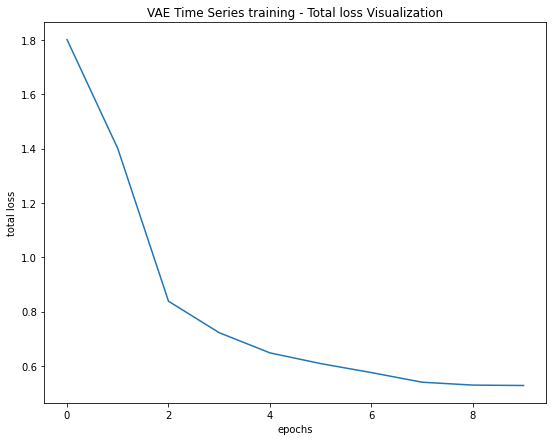

In [115]:
# VAE Training Visualization-
plt.figure(figsize = (9, 7))
plt.plot([train_history[x]['train_loss'] for x in train_history.keys()], label = 'train_loss')
plt.title("VAE Time Series training - Total loss Visualization")
plt.xlabel("epochs")
plt.ylabel("total loss")
plt.show()

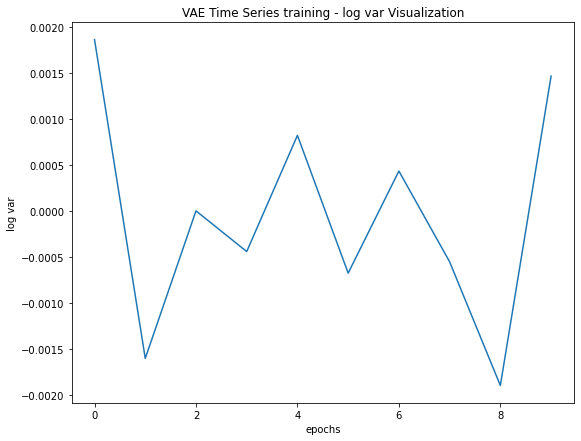

In [116]:
# VAE Training Visualization-
plt.figure(figsize = (9, 7))
plt.plot([train_history[x]['train_logvar'] for x in train_history.keys()], label = 'train_logvar')
plt.title("VAE Time Series training - log var Visualization")
plt.xlabel("epochs")
plt.ylabel("log var")
plt.show()

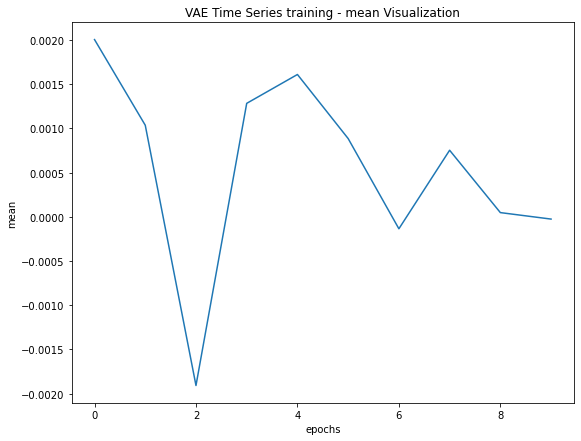

In [117]:
# VAE Training Visualization-
plt.figure(figsize = (9, 7))
plt.plot([train_history[x]['train_mu'] for x in train_history.keys()], label = 'mu_train')
plt.title("VAE Time Series training - mean Visualization")
plt.xlabel("epochs")
plt.ylabel("mean")
plt.show()

In [118]:
x = next(iter(data_loader))

In [119]:
# Perform forward propagation-
recon_data, mu, log_var = model(x)

In [120]:
recon_data = recon_data.cpu().detach().numpy()
mu = mu.cpu().detach().numpy()
log_var = log_var.cpu().detach().numpy()

In [121]:
recon_data.shape, x.shape, mu.shape, log_var.shape

((64, 14), torch.Size([64, 14]), (64, 10), (64, 10))

In [122]:
# for x in dataset:
for x in data_loader:
    x = x.to(device)
    
    recon_data_n, mu_n, log_var_n = model(x)
    
    recon_data_n = recon_data_n.detach().cpu().numpy()
    mu_n = mu_n.detach().cpu().numpy()
    log_var_n = log_var_n.detach().cpu().numpy()

    recon_data = np.concatenate((recon_data, recon_data_n), axis = 0)
    mu = np.concatenate((mu, mu_n), axis = 0)
    log_var = np.concatenate((log_var, log_var_n), axis = 0)
    
    """
    print(f"recon_data.shape: {recon_data.shape}, mu.shape: {mu.shape}"
         f" & log_var.shape: {log_var.shape}")
    """
    

In [123]:
recon_data.shape, mu.shape, log_var.shape

((420615, 14), (420615, 10), (420615, 10))

In [124]:
type(recon_data), type(mu), type(log_var)

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [125]:
recon_data_orig = mm_scaler.inverse_transform(recon_data)

In [126]:
recon_data_orig = pd.DataFrame(recon_data_orig, columns = cols)

In [127]:
data.loc[:5, :]

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
5,2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7


In [128]:
recon_data_orig.loc[:5, :]

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,1008.861267,-5.589265,266.356903,-6.872425,89.109276,4.102803,3.671323,0.406468,2.239503,3.596094,1320.166870,1.356020,2.275971,165.628387
1,1009.424133,-5.851975,266.109314,-7.100641,89.606094,4.029233,3.617514,0.382422,2.208613,3.546960,1322.049316,1.259863,2.133749,143.232880
2,1009.378662,-5.849324,266.077454,-7.066114,89.436958,4.035912,3.619995,0.388140,2.206310,3.542154,1321.968628,1.377921,2.303730,178.923279
3,1009.467407,-5.635225,266.283386,-6.850080,90.072357,4.118686,3.690723,0.366673,2.249763,3.609921,1321.108521,1.422249,2.362643,192.676361
4,1009.138794,-5.482256,266.421509,-6.874983,90.085976,4.209219,3.716740,0.371787,2.265795,3.629528,1320.616821,1.458745,2.388640,211.091873
5,1009.517883,-5.595650,266.331299,-6.763481,90.019279,4.128090,3.711557,0.372262,2.262777,3.631704,1320.867432,1.404469,2.339224,188.336258


In [129]:
recon_data_orig.sample(n = 10)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
323421,1000.757141,-0.371166,272.150696,-2.351492,85.136299,5.826116,5.070172,0.808951,3.139179,5.039440,1282.785645,1.371698,2.326677,91.283600
156443,1002.571045,1.467914,273.735168,-0.384841,90.612152,6.794502,5.930066,0.589126,3.666747,5.872581,1277.688232,1.283464,2.314390,262.260315
377230,992.045227,3.731211,276.840393,-0.927037,70.828163,7.867400,5.699627,2.180698,3.562393,5.713637,1251.678955,2.814818,4.972702,226.344940
364219,999.503906,2.034644,274.463409,0.644518,92.455925,6.982144,6.362566,0.449297,3.940905,6.313928,1271.349609,1.545899,2.526143,36.977310
72971,994.059692,8.507005,281.471252,6.392197,86.454399,11.152791,9.708918,1.482211,6.070263,9.708211,1231.516479,1.387499,2.343621,205.979752
325327,993.229004,12.815883,285.993530,9.199231,78.715050,14.736712,11.678026,3.152707,7.328439,11.711457,1209.323853,1.340602,2.306241,191.536392
235894,996.950684,10.026675,282.722473,7.707159,84.265244,12.230993,10.599215,1.919055,6.612808,10.577492,1228.278198,1.521406,2.766650,260.725677
13249,995.501282,5.416340,278.263184,1.497382,76.314827,8.716458,6.727996,1.827529,4.197552,6.730323,1248.759766,2.022458,3.285396,37.405357
150487,986.938293,12.772204,286.528442,10.023632,80.334839,15.104410,12.503593,3.151487,7.879903,12.586817,1201.577637,4.276856,6.913639,223.604095
142564,992.932617,16.991274,290.384796,8.880503,57.976913,18.981878,11.334653,7.836201,7.124619,11.397239,1190.200806,3.354573,5.254882,38.140228


In [130]:
for col in recon_data_orig.columns:
    print(f"{col} has {recon_data_orig[col].nunique()} unique values")

p (mbar) has 200287 unique values
T (degC) has 417241 unique values
Tpot (K) has 337671 unique values
Tdew (degC) has 416978 unique values
rh (%) has 401873 unique values
VPmax (mbar) has 410763 unique values
VPact (mbar) has 413447 unique values
VPdef (mbar) has 395368 unique values
sh (g/kg) has 413619 unique values
H2OC (mmol/mol) has 413454 unique values
rho (g/m**3) has 350906 unique values
wv (m/s) has 389320 unique values
max. wv (m/s) has 403171 unique values
wd (deg) has 411604 unique values


In [139]:
len(recon_data_orig), len(data)

(420615, 420551)

In [140]:
recon_data_orig = recon_data_orig.loc[64:, :]

In [141]:
recon_data_orig.shape, data.shape

((420551, 14), (420551, 15))

In [142]:
# Save reconstructed pd.DataFrame as CSV file-
recon_data_orig.to_csv("jena_climate_2009_2016_reconstructed.csv", index = False)

In [133]:
from sklearn.metrics import mean_squared_error

In [144]:
for col in cols:
    print(f"col: {col} has MSE = "
          f"{mean_squared_error(y_true = data[col], y_pred = recon_data_orig[col]):.4f}"
         )

col: p (mbar) has MSE = 95.4236
col: T (degC) has MSE = 2.7081
col: Tpot (K) has MSE = 4.8144
col: Tdew (degC) has MSE = 1.1830
col: rh (%) has MSE = 15.5345
col: VPmax (mbar) has MSE = 2.6029
col: VPact (mbar) has MSE = 0.2024
col: VPdef (mbar) has MSE = 1.6535
col: sh (g/kg) has MSE = 0.0930
col: H2OC (mmol/mol) has MSE = 0.2410
col: rho (g/m**3) has MSE = 354.7920
col: wv (m/s) has MSE = 0.5807
col: max. wv (m/s) has MSE = 1.2791
col: wd (deg) has MSE = 258.2982
